<a href="https://colab.research.google.com/github/ankit-rathi/Tradevesting/blob/main/Sector_Indices_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import datetime
import pytz
tz_NY = pytz.timezone('Asia/Kolkata')
datetime_NY = datetime.datetime.now(tz_NY)
print("Run date time (IST):", datetime_NY.strftime("%Y-%m-%d %H:%M:%S"))

gen_output = 0

Run date time (IST): 2024-05-30 10:34:55


In [2]:
# install libraries
!pip install yfinance
!pip install pandas-ta
#!pip install talib-binary

In [3]:
# import libraries

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web
import yfinance as yfin
#import talib
yfin.pdr_override()
import pandas_ta as ta

from google.colab import data_table

yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


In [4]:
# set start and end date
start_date = (datetime.date.today() + datetime.timedelta(days=-365)).strftime('%Y-%m-%d')
end_date = (datetime.date.today() + datetime.timedelta(days=1)).strftime('%Y-%m-%d')

In [5]:
# fetch nse indices scrips

import pandas as pd
import numpy as np

df_nse_sectors = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting/main/data/NSE_Sectors_Indices.csv')

In [6]:
sectors = df_nse_sectors['Sector'].unique()
df_sectors = pd.DataFrame()
for sector in sectors:
  stocks = df_nse_sectors[df_nse_sectors['Sector'] == sector]['Symbol'].values
  df_sector = pd.DataFrame()
  tweight = 0
  for stock in stocks:
    stock_df = yfin.Ticker(stock+'.NS').history(period='max', interval='1d')[map(str.title, ['open', 'close', 'low', 'high', 'volume'])]
    col = ['Close']
    stock_df = stock_df[col]
    stock_df['Split'] = 1
    weight = df_nse_sectors[df_nse_sectors['Symbol'] == stock]['Weight'].values[0]
    tweight = sum(df_nse_sectors[df_nse_sectors['Sector'] == sector]['Weight'].values)
    if stock == 'NESTLEIND':
      stock_df.loc[stock_df.index < '2024-01-01', 'Split'] = 10
    #stock_df[stock] = (stock_df[col]*weight)/(tweight*stock_df['Split'].values[0])
    stock_df[stock] = stock_df['Close']/stock_df['Split']
    col = [stock]
    stock_df = stock_df[col]
    df_sector = pd.concat([df_sector, stock_df], axis=1)

  df_sector[sector] = df_sector[stocks].sum(axis=1)
  col = [sector]
  df_sector = df_sector[col]
  df_sectors = pd.concat([df_sectors, df_sector], axis=1)
df_sectors

,AUTO,BANKS,FINANCE,IT,FMCG,PHARMA,MEDIA,METAL,INFRA,CHEMICAL,CEMENT,DURABLES,JEWELLERY,TEXTILES,FOOTWEAR
Date,,,,,,,,,,,,,,,
1991-01-02 00:00:00+05:30,15.738645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-01-03 00:00:00+05:30,15.738645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-01-04 00:00:00+05:30,15.738645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-01-07 00:00:00+05:30,15.199651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-01-08 00:00:00+05:30,15.199651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-24 00:00:00+05:30,32845.750183,6355.199829,10033.699829,13284.949921,13110.250305,18423.249878,2897.050003,6671.699921,27129.449600,22688.649857,40724.548767,23002.000244,4488.599915,5990.787983,4102.600006
2024-05-27 00:00:00+05:30,32745.849854,6389.200012,10128.100052,13345.899841,13072.599976,18540.350220,2922.100060,6563.350098,27145.499786,22342.799973,40665.949341,23046.300323,4473.099915,5900.789970,4109.199966
2024-05-28 00:00:00+05:30,32744.299744,6375.650024,10107.149872,13322.450134,13092.799805,18792.899780,2972.949951,6515.149994,26982.000259,21875.550522,40815.300903,22684.950256,4466.499908,6194.300152,4108.250015


In [7]:
def stock_prec_dev(stock_symbol):
    #print(stock_symbol)
    #stock_symbol = 'ULTRACEMCO.NS'
    short_window = 20
    mid_window = 50
    long_window = 200
    moving_avg = 'SMA'

    # import the closing price data of the stock for the aforementioned period of time in Pandas dataframe
    start = datetime.datetime(*map(int, start_date.split('-')))
    end = datetime.datetime(*map(int, end_date.split('-')))

    stock_df = df_sectors[[stock_symbol]]
    stock_df.columns = ['Close']

    #stock_df['Max'] = round(max(stock_df['Close']),2)
    stock_df['Max']  = round(stock_df['Close'].dropna().max(), 2)
    stock_df = stock_df[(stock_df.index <= end_date) & (stock_df.index >= start_date)]
    stock_df['200_SMA'] = round(stock_df['Close'].rolling(window = 200, min_periods = 1).mean(),0)
    stock_df['Dev%_200'] = round((stock_df['Close'] - stock_df['200_SMA'])*100/stock_df['200_SMA'],2)
    stock_df.dropna(axis = 0, inplace = True) # remove any null rows

    stock_df['Sector'] = stock_symbol

    stock_df['Close'] = round(stock_df['Close'],2)

    #stock_df['Min'] = round(min(stock_df['Close']),2)
    stock_df['Min']  = round(stock_df['Close'].dropna().min(), 2)
    #stock_df['Gained%'] = round((stock_df['Close'] - stock_df['Min'])*100/stock_df['Min'],2)
    stock_df.ta.rsi(append=True)
    #stock_df.rename(columns={'RSI_14':'RSI'}, inplace=True)
    #stock_df['Close'] = round(stock_df['Close'],0)
    stock_df['RSI_14'] = round(stock_df['RSI_14'],0)
    stock_df['ATH%'] = round((stock_df['Max'] - stock_df['Close'])*100/stock_df['Close'],2)
    #stock_df['Sector'] = stock_symbol
    stock_df = stock_df.tail(1)
    return stock_df

In [8]:
df_final =  pd.DataFrame()
for sector in sectors:

  df_tmp = stock_prec_dev(sector)
  df_final = pd.concat([df_final, df_tmp], ignore_index = True) #df_final.append(df_tmp)
# all sectors
df_final = df_final.sort_values(by = 'ATH%', ascending=False)
#data_table.DataTable(df_final, include_index=False)
df_final

,Close,Max,200_SMA,Dev%_200,Sector,Min,RSI_14,ATH%
6,2968.90,3802.31,3299.0,-10.01,MEDIA,1417.53,58.0,28.07
3,13062.80,16437.29,13553.0,-3.62,IT,11636.83,43.0,25.83
14,4187.30,4947.39,4356.0,-3.87,FOOTWEAR,3589.40,67.0,18.15
12,4337.00,5100.03,4576.0,-5.22,JEWELLERY,3771.26,36.0,17.59
1,5489.00,6389.20,5994.0,-8.43,BANKS,5489.00,23.0,16.40
10,39586.25,44858.64,40060.0,-1.18,CEMENT,14617.05,45.0,13.32
8,25129.95,27331.45,24164.0,4.00,INFRA,19272.41,33.0,8.76
2,9844.25,10620.93,9869.0,-0.25,FINANCE,8713.73,46.0,7.89
9,21883.60,23420.15,19243.0,13.72,CHEMICAL,15833.32,47.0,7.02
4,12901.50,13504.04,11263.0,14.55,FMCG,7987.18,51.0,4.67


<Axes: xlabel='Date'>

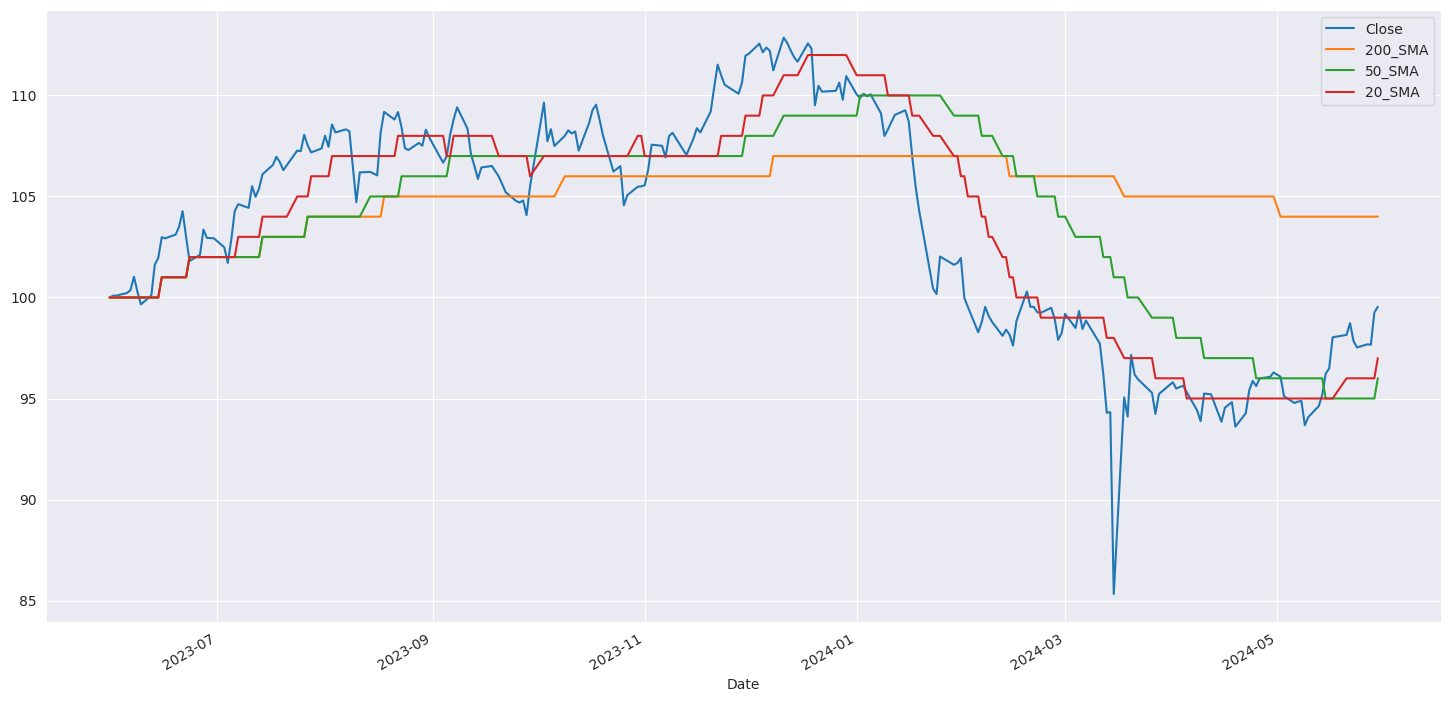

In [13]:
col = ['FOOTWEAR']
sector_df = df_sectors[col]
sector_df.columns = ['Close']
sector_df['200_SMA'] = round(sector_df['Close'].rolling(window = 200, min_periods = 1).mean(),0)
sector_df['50_SMA'] = round(sector_df['Close'].rolling(window = 50, min_periods = 1).mean(),0)
sector_df['20_SMA'] = round(sector_df['Close'].rolling(window = 20, min_periods = 1).mean(),0)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')
tmp_df = sector_df.reset_index()
tmp_df.plot(x='Date', y=['Close','200_SMA','50_SMA','20_SMA'], figsize=(18,9))

In [10]:
df_sectors = df_sectors[(df_sectors.index <= end_date) & (df_sectors.index >= start_date)]
for sector in sectors:
  base_value = df_sectors[sector].head(1).values[0]
  df_sectors[sector] = df_sectors[sector]*100/base_value

df_sectors

,AUTO,BANKS,FINANCE,IT,FMCG,PHARMA,MEDIA,METAL,INFRA,CHEMICAL,CEMENT,DURABLES,JEWELLERY,TEXTILES,FOOTWEAR
Date,,,,,,,,,,,,,,,
2023-05-31 00:00:00+05:30,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2023-06-01 00:00:00+05:30,100.271945,98.403396,100.564631,100.096154,99.965327,100.789016,100.074027,99.762471,100.690120,99.932946,100.169322,100.796599,100.099037,100.584159,100.088524
2023-06-02 00:00:00+05:30,101.945995,98.800950,100.557230,100.087841,100.468837,101.311997,99.700686,99.745351,101.700605,99.869280,99.921800,101.165265,101.837501,101.110389,100.095734
2023-06-05 00:00:00+05:30,102.799239,99.088707,100.833129,99.471674,100.515245,101.004048,101.229307,99.603403,102.074751,99.543091,99.409751,101.157877,102.312702,101.626612,100.223766
2023-06-06 00:00:00+05:30,104.150774,99.753833,101.850193,98.024045,100.616141,101.993251,101.878478,99.427755,103.251381,99.158707,102.861344,100.374358,102.911836,102.426536,100.364014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-24 00:00:00+05:30,167.973202,105.437672,115.148181,110.581052,136.907030,141.029023,104.211551,149.346842,140.768357,136.824482,109.444101,192.470763,119.021327,118.491193,97.524968
2024-05-27 00:00:00+05:30,167.462312,106.001761,116.231531,111.088386,136.513857,141.925420,105.112642,146.921417,140.851637,134.738825,109.286619,192.841447,118.610323,116.711131,97.681859
2024-05-28 00:00:00+05:30,167.454384,105.776957,115.991104,110.893196,136.724798,143.858674,106.941794,145.842452,140.003277,131.921065,109.687990,189.817826,118.435315,122.516440,97.659277


<Axes: xlabel='Date'>

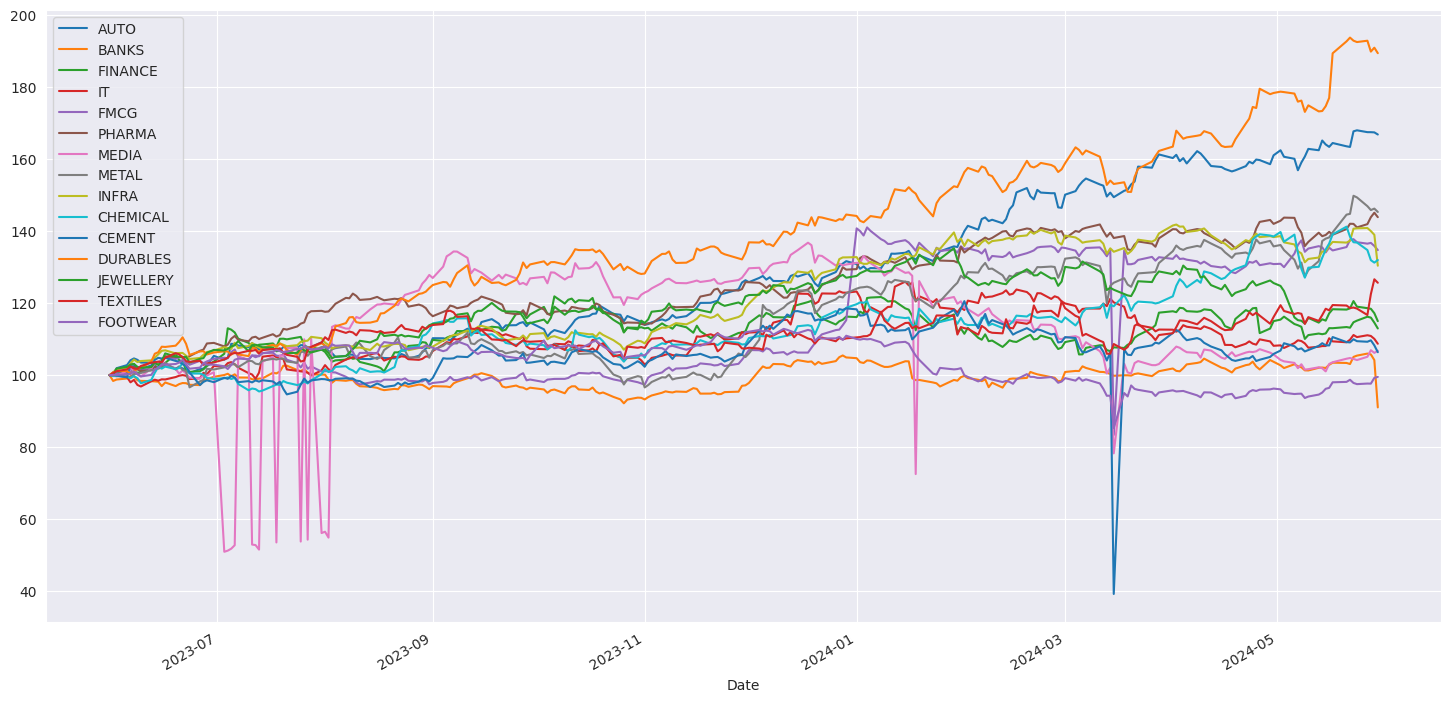

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')
tmp_df = df_sectors.reset_index()
tmp_df.plot(x='Date', y=['AUTO', 'BANKS', 'FINANCE', 'IT', 'FMCG', 'PHARMA', 'MEDIA', 'METAL', 'INFRA', 'CHEMICAL', 'CEMENT', 'DURABLES', 'JEWELLERY', 'TEXTILES', "FOOTWEAR"], figsize=(18,9))

In [12]:
tmp_df

,Date,AUTO,BANKS,FINANCE,IT,FMCG,PHARMA,MEDIA,METAL,INFRA,CHEMICAL,CEMENT,DURABLES,JEWELLERY,TEXTILES,FOOTWEAR
0,2023-05-31 00:00:00+05:30,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,2023-06-01 00:00:00+05:30,100.271945,98.403396,100.564631,100.096154,99.965327,100.789016,100.074027,99.762471,100.690120,99.932946,100.169322,100.796599,100.099037,100.584159,100.088524
2,2023-06-02 00:00:00+05:30,101.945995,98.800950,100.557230,100.087841,100.468837,101.311997,99.700686,99.745351,101.700605,99.869280,99.921800,101.165265,101.837501,101.110389,100.095734
3,2023-06-05 00:00:00+05:30,102.799239,99.088707,100.833129,99.471674,100.515245,101.004048,101.229307,99.603403,102.074751,99.543091,99.409751,101.157877,102.312702,101.626612,100.223766
4,2023-06-06 00:00:00+05:30,104.150774,99.753833,101.850193,98.024045,100.616141,101.993251,101.878478,99.427755,103.251381,99.158707,102.861344,100.374358,102.911836,102.426536,100.364014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,2024-05-24 00:00:00+05:30,167.973202,105.437672,115.148181,110.581052,136.907030,141.029023,104.211551,149.346842,140.768357,136.824482,109.444101,192.470763,119.021327,118.491193,97.524968
241,2024-05-27 00:00:00+05:30,167.462312,106.001761,116.231531,111.088386,136.513857,141.925420,105.112642,146.921417,140.851637,134.738825,109.286619,192.841447,118.610323,116.711131,97.681859
242,2024-05-28 00:00:00+05:30,167.454384,105.776957,115.991104,110.893196,136.724798,143.858674,106.941794,145.842452,140.003277,131.921065,109.687990,189.817826,118.435315,122.516440,97.659277
243,2024-05-29 00:00:00+05:30,167.400180,104.199175,114.588723,110.088282,135.880502,145.105666,106.195384,146.243148,138.967342,131.245946,108.278975,190.908959,117.211584,126.624513,99.255534
